<a href="https://colab.research.google.com/github/akshitsehgal/image-based-search-engine/blob/main/image_based_search_engine_labelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image based search engine using labeled data

## Get the helper functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the helper functions scripts
!wget https://raw.githubusercontent.com/akshitsehgal/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-11 15:04:41--  https://raw.githubusercontent.com/akshitsehgal/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-11 15:04:41 (69.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper functions we wanna use
from helper_functions import unzip_data,walk_through_dir,plot_loss_curves, compare_historys, create_tensorboard_callback , load_and_prep_image

## Get our data

In [ ]:
unzip_data('/content/drive/MyDrive/content_based_search_engine/pins_dataset.zip')

In [ ]:
walk_through_dir('/content/105_classes_pins_dataset')

There are 105 directories and 0 images in '/content/105_classes_pins_dataset'.
There are 0 directories and 188 images in '/content/105_classes_pins_dataset/pins_ellen page'.
There are 0 directories and 203 images in '/content/105_classes_pins_dataset/pins_kiernen shipka'.
There are 0 directories and 154 images in '/content/105_classes_pins_dataset/pins_Christian Bale'.
There are 0 directories and 178 images in '/content/105_classes_pins_dataset/pins_Mark Ruffalo'.
There are 0 directories and 212 images in '/content/105_classes_pins_dataset/pins_Logan Lerman'.
There are 0 directories and 182 images in '/content/105_classes_pins_dataset/pins_Johnny Depp'.
There are 0 directories and 175 images in '/content/105_classes_pins_dataset/pins_Morena Baccarin'.
There are 0 directories and 146 images in '/content/105_classes_pins_dataset/pins_Dominic Purcell'.
There are 0 directories and 139 images in '/content/105_classes_pins_dataset/pins_Emma Stone'.
There are 0 directories and 102 images in '

In [ ]:
!pip install split-folders

import splitfolders

input_folder = '/content/105_classes_pins_dataset/'

splitfolders.ratio(input=input_folder,output='/content/105_classes_pins_split_dataset4',
                   seed=47,ratio=(0.8,0.15,0.05),
                   group_prefix=None)



Copying files: 17534 files [00:17, 1008.21 files/s]


In [ ]:
walk_through_dir('/content/105_classes_pins_split_dataset4')

There are 3 directories and 0 images in '/content/105_classes_pins_split_dataset4'.
There are 105 directories and 0 images in '/content/105_classes_pins_split_dataset4/train'.
There are 0 directories and 181 images in '/content/105_classes_pins_split_dataset4/train/pins_ellen page'.
There are 0 directories and 195 images in '/content/105_classes_pins_split_dataset4/train/pins_kiernen shipka'.
There are 0 directories and 148 images in '/content/105_classes_pins_split_dataset4/train/pins_Christian Bale'.
There are 0 directories and 170 images in '/content/105_classes_pins_split_dataset4/train/pins_Mark Ruffalo'.
There are 0 directories and 203 images in '/content/105_classes_pins_split_dataset4/train/pins_Logan Lerman'.
There are 0 directories and 174 images in '/content/105_classes_pins_split_dataset4/train/pins_Johnny Depp'.
There are 0 directories and 167 images in '/content/105_classes_pins_split_dataset4/train/pins_Morena Baccarin'.
There are 0 directories and 137 images in '/conten

## Preprocess the data

### Create training,validation and testing directories

In [ ]:
train_dir = '/content/105_classes_pins_split_dataset4/train'
val_dir = '/content/105_classes_pins_split_dataset4/val'
test_dir = '/content/105_classes_pins_split_dataset4/test'


In [ ]:

import tensorflow as tf

tf.random.set_seed(47)

IMAGE_SHAPE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size=IMAGE_SHAPE,seed = 47)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size=IMAGE_SHAPE,seed = 47)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size=IMAGE_SHAPE, seed = 47,shuffle=False)


Found 16846 files belonging to 105 classes.
Found 4779 files belonging to 105 classes.
Found 1962 files belonging to 105 classes.


In [ ]:
class_names = train_data.class_names

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

### Tensorboard, ModelCheckpoint, EarlyStopping callbacks

In [ ]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a model checkpoint callback to save the models weights during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True, # Save weights only not the whole model
                                                      verbose=0)  # Don't print out whether the model is being saved or not

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 2,
                                                  min_delta = 1e-6)                                                      

# Data augmentation layer

In [ ]:
# Create a data augmentation layer to incoperate it right into our model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

data_augmentation = Sequential([
                    preprocessing.RandomFlip(mode = 'horizontal'),
                    preprocessing.RandomHeight(0.2),
                    preprocessing.RandomRotation(0.2),
                    preprocessing.RandomWidth(0.2),
                    preprocessing.RandomZoom(0.2),
                    preprocessing.Rescaling(1./255)     # For models like ResNet50V2, Efficienet has rescaling built-in        
], name = 'data_augmentation')

## Build a feature extractor model



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
# Create the base model
base_model = tf.keras.applications.InceptionV3(include_top=False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape=input_shape,name='input_layer')
x = data_augmentation(inputs)
# If using a model that doesn't have rescaling built in
#x = preprocessing.Rescaling(1/255.) # EfficientNet has built-in rescaling
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name='global_average_layer')(x)
x = layers.Dense(len(class_names))(x)# want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation('softmax',dtype=tf.float32, name= 'output_layer')(x)
# Create the model
model = tf.keras.Model(inputs,outputs)

# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_layer (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 105)               215145    
_________________________________________________________________
output_layer (Activation)    (None, 105)               0         
Total params: 22,017,929
Trainable params: 215,145
Non-trainable params: 21,802,784
___________________________________________

## Check our layer

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable)


input_layer True
data_augmentation True
inception_v3 False
global_average_layer True
dense True
output_layer True


In [ ]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

## Fit the feature extractor model

In [ ]:
history = model.fit(train_data,
                    epochs=50,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = len(val_data),
                    callbacks=[create_tensorboard_callback('transfer_learning','feature_extractor_big'),model_checkpoint,early_stopping_callback])

Saving TensorBoard log files to: transfer_learning/feature_extractor_big/20210911-150506
Epoch 1/50
437/437 [==============================] - 298s 669ms/step - loss: 4.2025 - accuracy: 0.0849 - val_loss: 3.6085 - val_accuracy: 0.1437
Epoch 2/50
437/437 [==============================] - 189s 432ms/step - loss: 3.6190 - accuracy: 0.1605 - val_loss: 3.4462 - val_accuracy: 0.1752
Epoch 3/50
437/437 [==============================] - 165s 377ms/step - loss: 3.4243 - accuracy: 0.1892 - val_loss: 3.2903 - val_accuracy: 0.2172
Epoch 4/50
437/437 [==============================] - 151s 344ms/step - loss: 3.3285 - accuracy: 0.2095 - val_loss: 3.2549 - val_accuracy: 0.2141
Epoch 5/50
437/437 [==============================] - 139s 317ms/step - loss: 3.2457 - accuracy: 0.2309 - val_loss: 3.1551 - val_accuracy: 0.2350
Epoch 6/50
437/437 [==============================] - 130s 297ms/step - loss: 3.1576 - accuracy: 0.2442 - val_loss: 3.1385 - val_accuracy: 0.2378
Epoch 7/50
437/437 [===============

In [ ]:
# Evaluate the model
results_feature_extractor=model.evaluate(test_data)
results_feature_extractor

31/31 [==============================] - 6s 177ms/step - loss: 3.0296 - accuracy: 0.2579


[3.0296316146850586, 0.25790008902549744]

## Save and load the model

In [ ]:

# Save our model
model.save('/content/drive/MyDrive/content_based_search_engine')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/content_based_search_engine/assets


In [ ]:
# Load our model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/content_based_search_engine/')

In [ ]:
# evaluate our loaded model and compare with previous model results
results_loaded_model = loaded_model.evaluate(test_data)

31/31 [==============================] - 7s 182ms/step - loss: 3.0296 - accuracy: 0.2579


## Setting up model for fine tuning

In [ ]:
# Set all the layers in the model trainable
loaded_model.trainable = True

# Recompile the model
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics= ['accuracy'])

In [ ]:
# Get the model summar
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_layer (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 105)               215145    
_________________________________________________________________
output_layer (Activation)    (None, 105)               0         
Total params: 22,017,929
Trainable params: 21,983,497
Non-trainable params: 34,432
____________________________________________

In [ ]:
# Check the layers
for layer_no, layer in enumerate(loaded_model.layers[2].layers):
  print(layer_no,layer.name,layer.trainable)

0 input_1 True
1 conv2d True
2 batch_normalization True
3 activation True
4 conv2d_1 True
5 batch_normalization_1 True
6 activation_1 True
7 conv2d_2 True
8 batch_normalization_2 True
9 activation_2 True
10 max_pooling2d True
11 conv2d_3 True
12 batch_normalization_3 True
13 activation_3 True
14 conv2d_4 True
15 batch_normalization_4 True
16 activation_4 True
17 max_pooling2d_1 True
18 conv2d_8 True
19 batch_normalization_8 True
20 activation_8 True
21 conv2d_6 True
22 conv2d_9 True
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 True
26 activation_9 True
27 average_pooling2d True
28 conv2d_5 True
29 conv2d_7 True
30 conv2d_10 True
31 conv2d_11 True
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 True
37 activation_7 True
38 activation_10 True
39 activation_11 True
40 mixed0 True
41 conv2d_15 True
42 batch_normalization_15 True
43 activation_15 True
44 conv2d_13 True
45

## Fit the model with all layers trainable

In [ ]:
# Fit the model
history_big = loaded_model.fit(train_data,
                               epochs=100,
                               steps_per_epoch=len(train_data),
                               validation_data=val_data,
                               validation_steps=len(val_data),
                               initial_epoch = history.epoch[-1],
                               callbacks = [create_tensorboard_callback('transfer_learning','face_reg_fine_tuned_big'),
                                            model_checkpoint,
                                            early_stopping_callback])


Saving TensorBoard log files to: transfer_learning/face_reg_fine_tuned_big/20210911-154705
Epoch 11/100
437/437 [==============================] - 412s 924ms/step - loss: 2.7688 - accuracy: 0.2946 - val_loss: 2.0035 - val_accuracy: 0.4643
Epoch 12/100
437/437 [==============================] - 444s 1s/step - loss: 1.8750 - accuracy: 0.4907 - val_loss: 1.7350 - val_accuracy: 0.5423
Epoch 13/100
437/437 [==============================] - 398s 910ms/step - loss: 1.4544 - accuracy: 0.5932 - val_loss: 1.3652 - val_accuracy: 0.6239
Epoch 14/100
437/437 [==============================] - 371s 848ms/step - loss: 1.1537 - accuracy: 0.6727 - val_loss: 1.2024 - val_accuracy: 0.6585
Epoch 15/100
437/437 [==============================] - 352s 804ms/step - loss: 0.9490 - accuracy: 0.7287 - val_loss: 1.2385 - val_accuracy: 0.6678
Epoch 16/100
437/437 [==============================] - 338s 772ms/step - loss: 0.7836 - accuracy: 0.7689 - val_loss: 1.1858 - val_accuracy: 0.6943
Epoch 17/100
437/437 [==

In [ ]:
# Evaluate the model
loaded_model.evaluate(test_data)

31/31 [==============================] - 6s 179ms/step - loss: 0.9512 - accuracy: 0.7472


[0.9511776566505432, 0.7471967339515686]

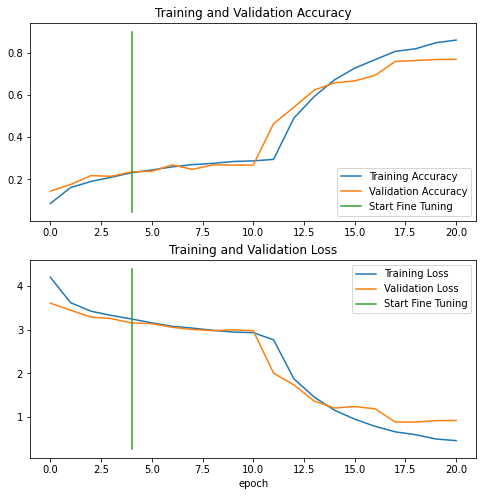

In [ ]:
# Compare historys
compare_historys(history,history_big,initial_epochs=5)

In [ ]:
# Save the model
loaded_model.save('/content/drive/MyDrive/content_based_search_engine/105_pins_fine_tuned')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/content_based_search_engine/105_pins_fine_tuned/assets


In [ ]:
import tensorflow as tf
loaded_model_fine_tuned = tf.keras.models.load_model('/content/drive/MyDrive/content_based_search_engine/105_pins_fine_tuned')


In [ ]:
loaded_model_fine_tuned.evaluate(test_data)

31/31 [==============================] - 7s 179ms/step - loss: 0.9512 - accuracy: 0.7472


[0.9511776566505432, 0.7471967339515686]

## Make predictions on custom data

### Create a function that predicts input image and outputs similar images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
import os

def find_similar_images(img_dir,img_shape = 224,scale=False):
  img = load_and_prep_image(img_dir,img_shape = img_shape,scale=scale)
  pred_probs = loaded_model_fine_tuned.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_probs.argmax()]
  selected_image = mping.imread(img_dir)
  plt.imshow(selected_image)
  plt.title(f'Selected image: {pred_class} ')
  plt.axis(False)
  data_filepath = '/content/105_classes_pins_split_dataset4/train'
  for i in range(20):
    class_filepath = data_filepath + '/' + pred_class
    random_image =  random.choice(os.listdir(class_filepath))
    random_image_filepath = class_filepath + '/' + random_image
    image = mping.imread(random_image_filepath)
    plt.figure()
    plt.imshow(image)
    plt.title('Similar images are')
    plt.axis(False)
    
  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


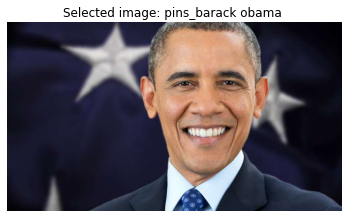

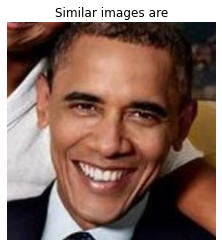

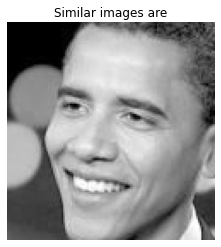

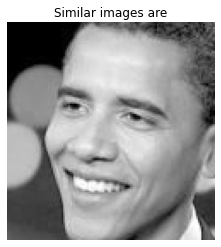

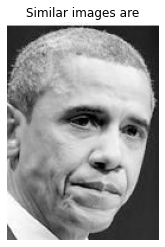

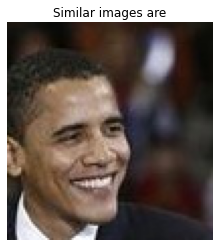

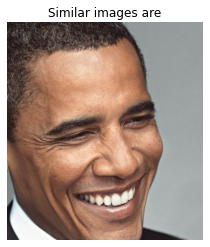

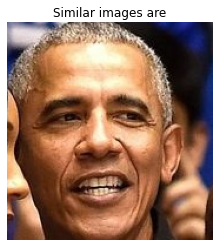

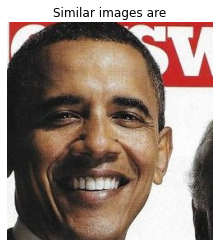

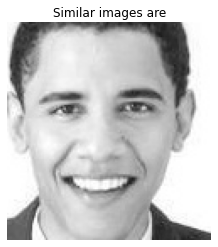

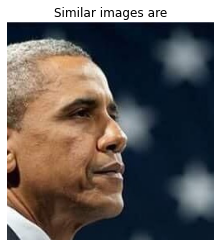

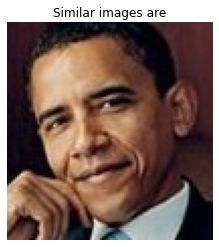

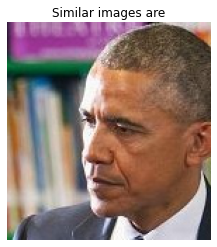

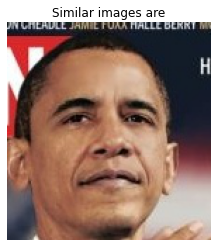

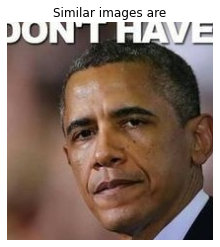

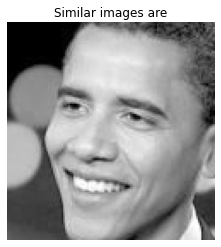

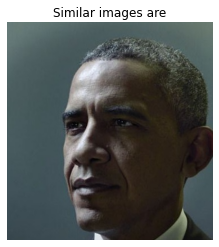

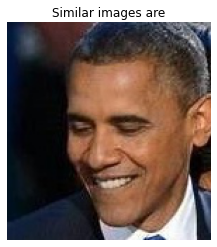

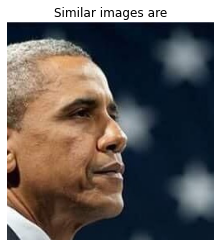

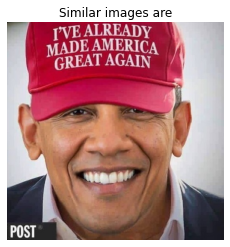

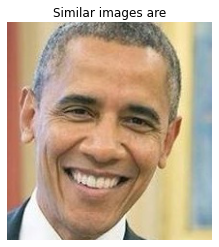

In [ ]:
find_similar_images('/content/drive/MyDrive/content_based_search_engine/images/barack_obama.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


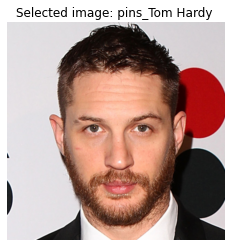

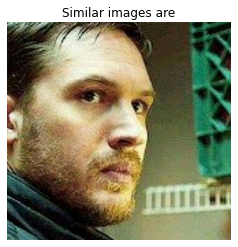

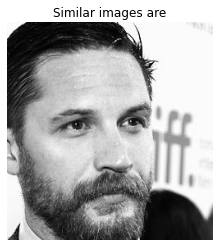

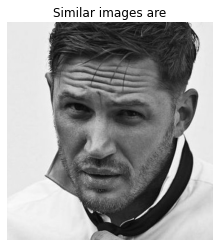

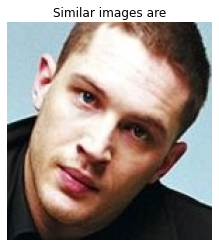

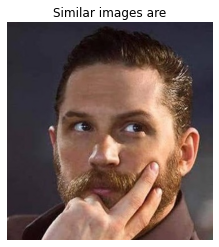

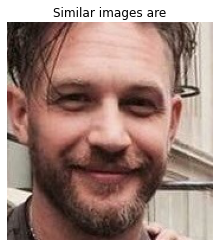

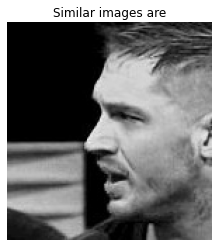

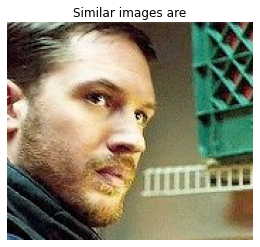

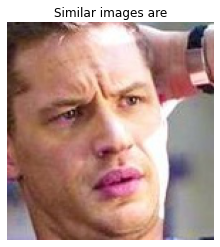

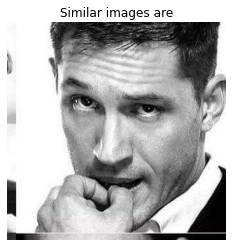

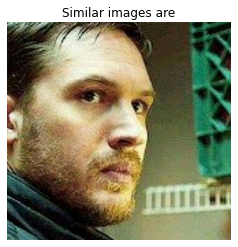

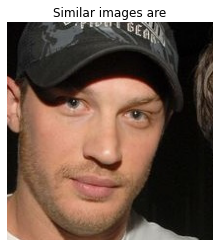

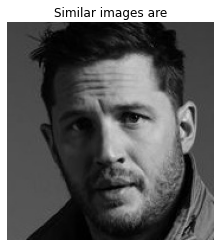

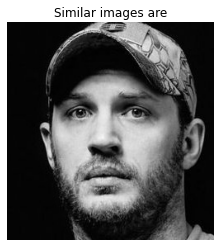

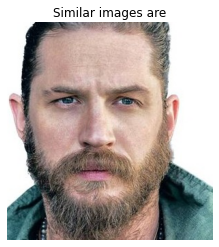

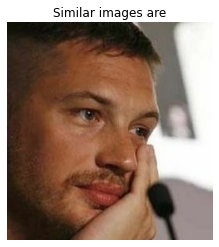

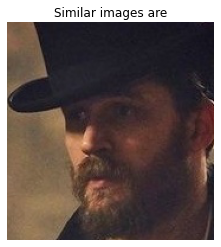

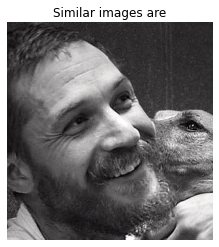

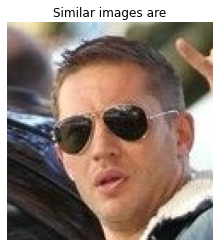

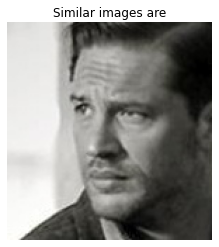

In [ ]:
find_similar_images('/content/drive/MyDrive/content_based_search_engine/images/tom_hardy.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


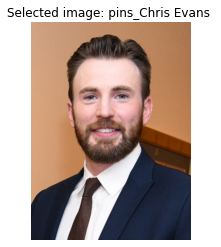

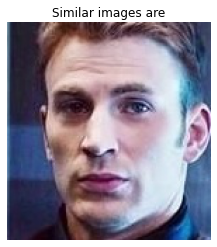

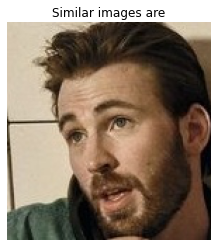

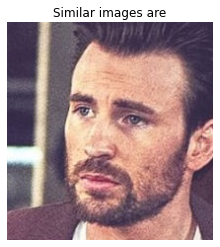

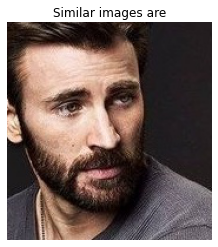

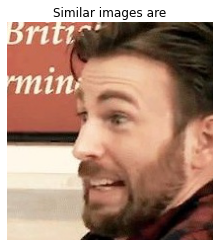

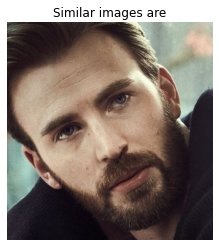

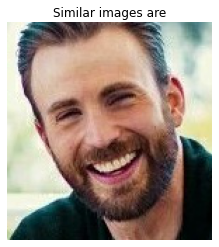

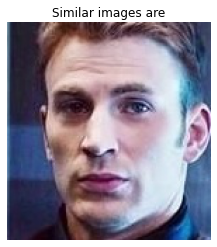

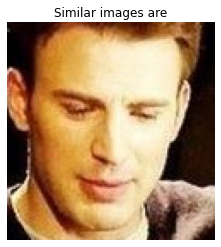

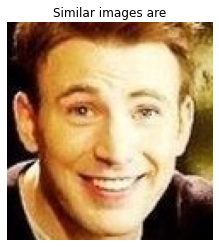

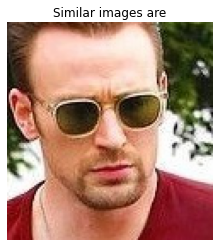

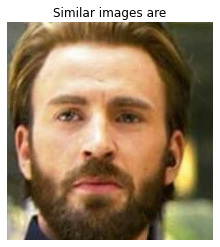

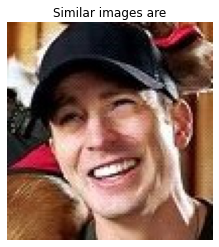

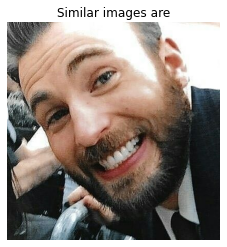

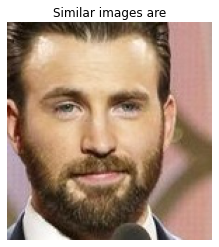

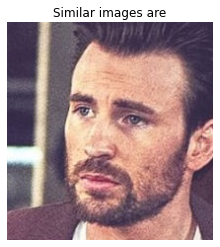

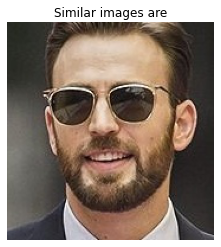

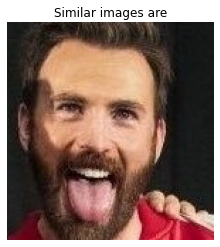

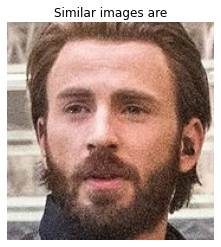

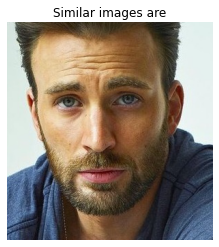

In [ ]:
find_similar_images('/content/drive/MyDrive/content_based_search_engine/images/Chris_evs.jpg')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


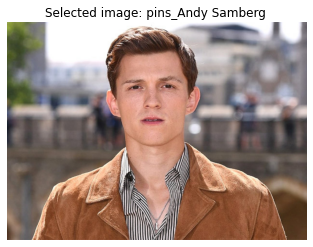

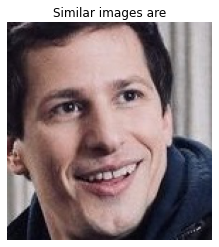

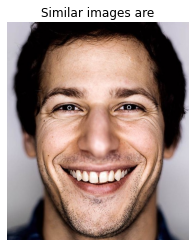

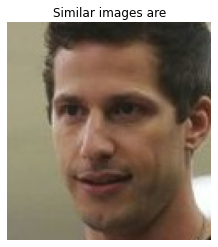

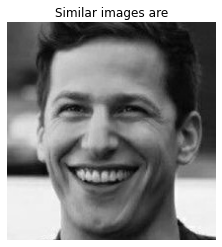

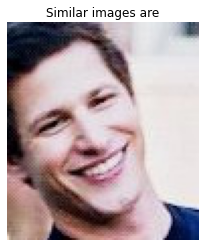

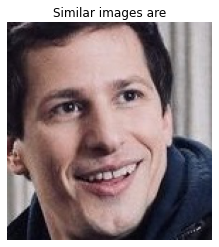

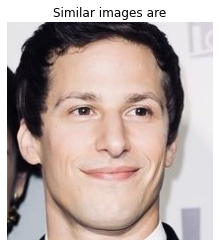

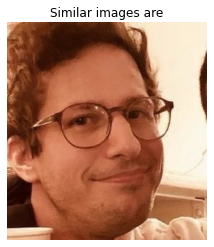

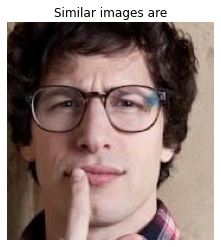

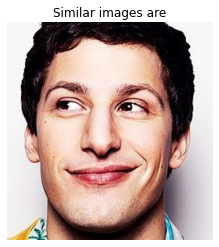

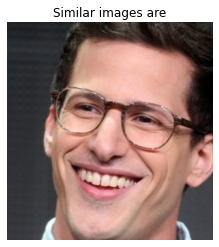

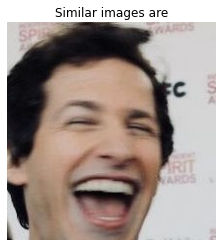

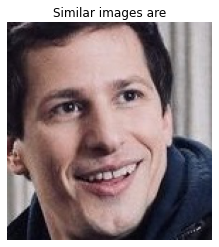

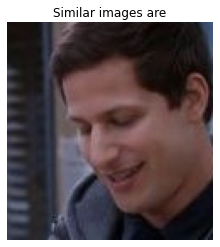

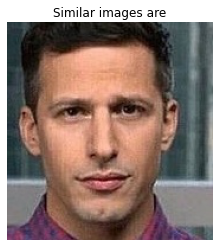

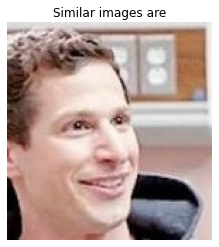

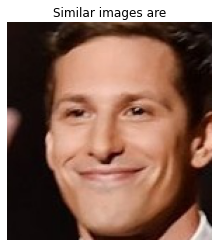

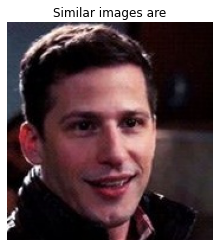

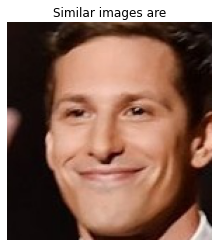

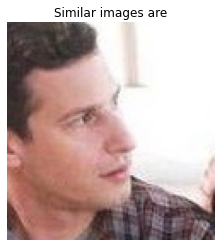

In [ ]:
find_similar_images('/content/drive/MyDrive/content_based_search_engine/images/tom_holl.jpg')

## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [ ]:
import numpy as np

# Get the y labels
y_labels = []

for images,labels in test_data.unbatch():
  y_labels.append(np.argmax(labels))



In [ ]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:

pred_probs = loaded_model_fine_tuned.predict(test_data)
pred_labels = np.argmax(pred_probs,axis=1)

In [ ]:
pred_labels[:10]

array([70,  0, 70,  0,  0, 47,  0,  0, 53,  0])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_labels,pred_labels)

0.8165137614678899